# Self-Driving Car Engineer Nanodegree | Image Processing
## Project: Advanced Lane Finding Project
### by Mohit Arvind Khakharia


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Camera Calibration 
First, I'll compute the camera calibration using chessboard images.
### Assumption
* Chessboard doesn't have a depth/height and is fixed on the (x, y) plane at z=0
### Steps
* Calculate object points and image points.
* "object points", which will be the (x, y, z) coordinates of the chessboard corners in a perfect scenario.
* img_points will be appended with the (x, y) pixel position of each of the corners in the image.
* Note - Chessboard size is 9x6
* cv2.findChessboardCorners: to find corners
* cv2.drawChessboardCorners: to draw the corner
* cv2.calibrateCamera: to calibrate camera
* Around three images fail in calibration.


In [16]:
## ALL IMPORT STATEMENTS
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


### Get Object and Image points

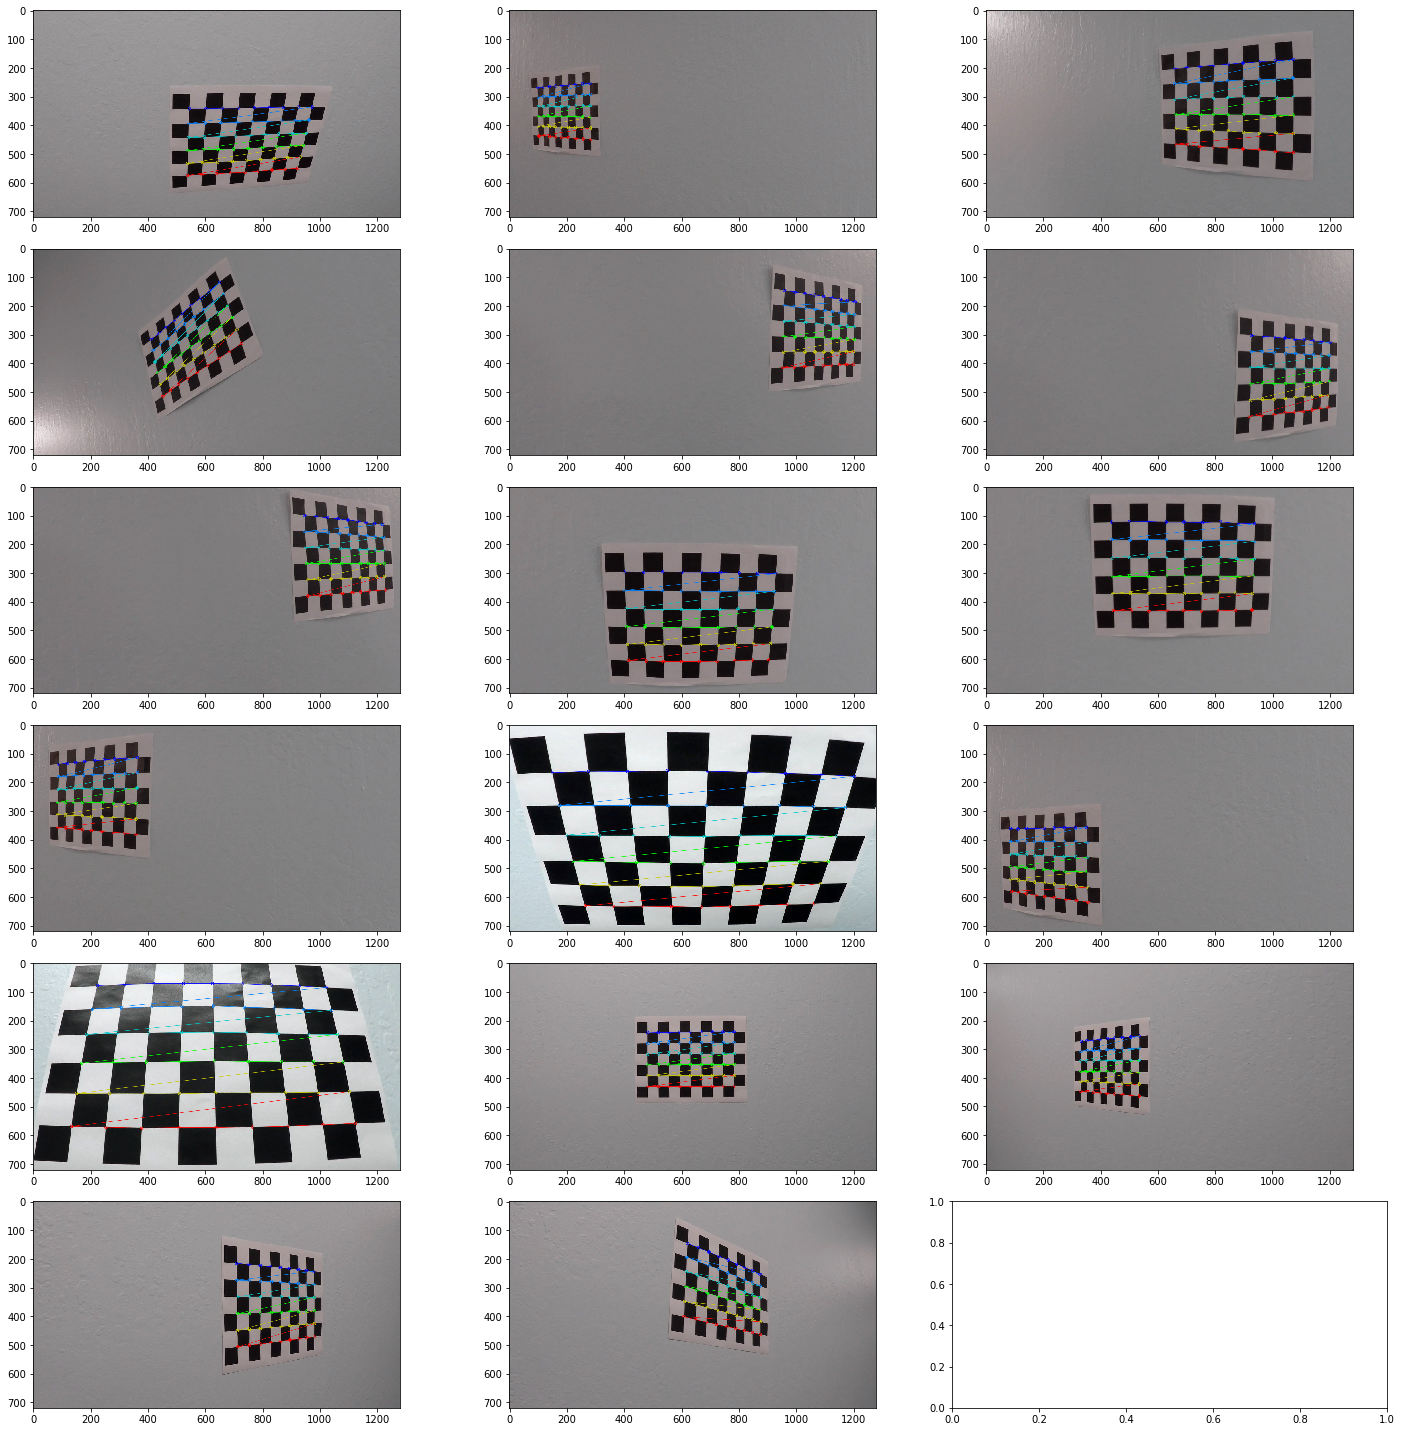

In [14]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# print(images)

f, axarr2D = plt.subplots(6, 3, figsize=(20,20))
f.subplots_adjust(hspace = .2, wspace=.001)
axarr1D = axarr2D.ravel()
plt.tight_layout()
i=0
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        axarr1D[i].imshow(img)
        axarr1D[i].axis('on')
        i =  i + 1
#cv2.destroyAllWindows()

### Distortion Removal

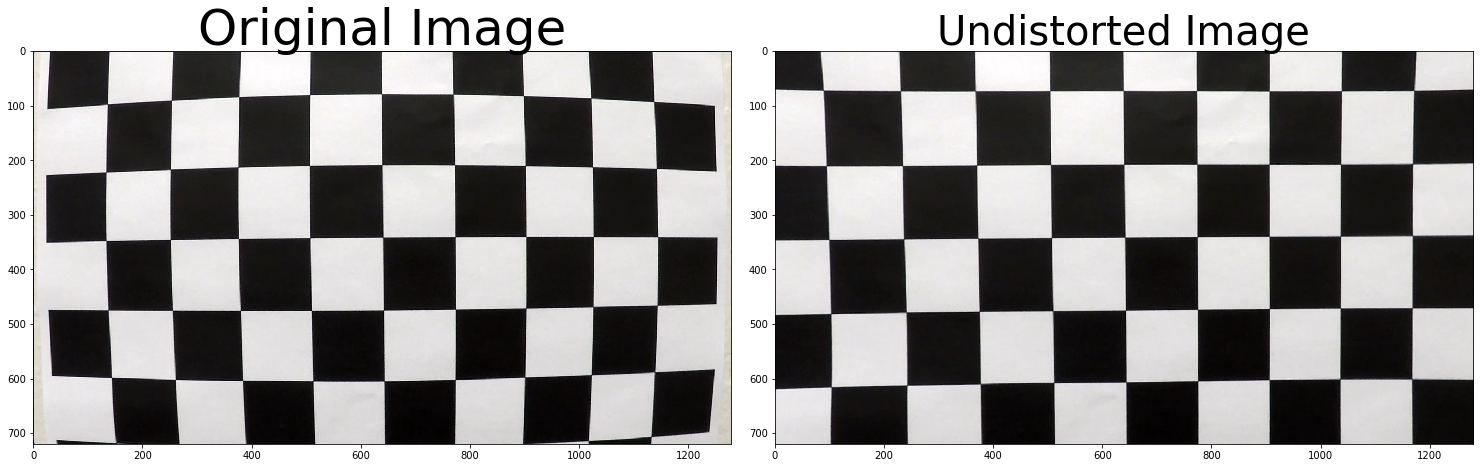

In [65]:
#reference - Udacity - Self Driving Car Nanodegree - Lesson 15, Topic 10
# Read a sample chessboard image
img = mpimg.imread('camera_cal/calibration1.jpg')

# Using the image points and object points the camera is calibrates calibration and later undistortion.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)


# Helper function to undistort the original image and compare it with original side-by-side.
def undistort_image(img):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(cv2.undistort(img, mtx, dist, None, mtx))
    ax2.set_title('Undistorted Image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=1.5, bottom=0.)

undistort_image(img)


### Undistort a real test image
* Note the car on the left of the original image is clipped off.

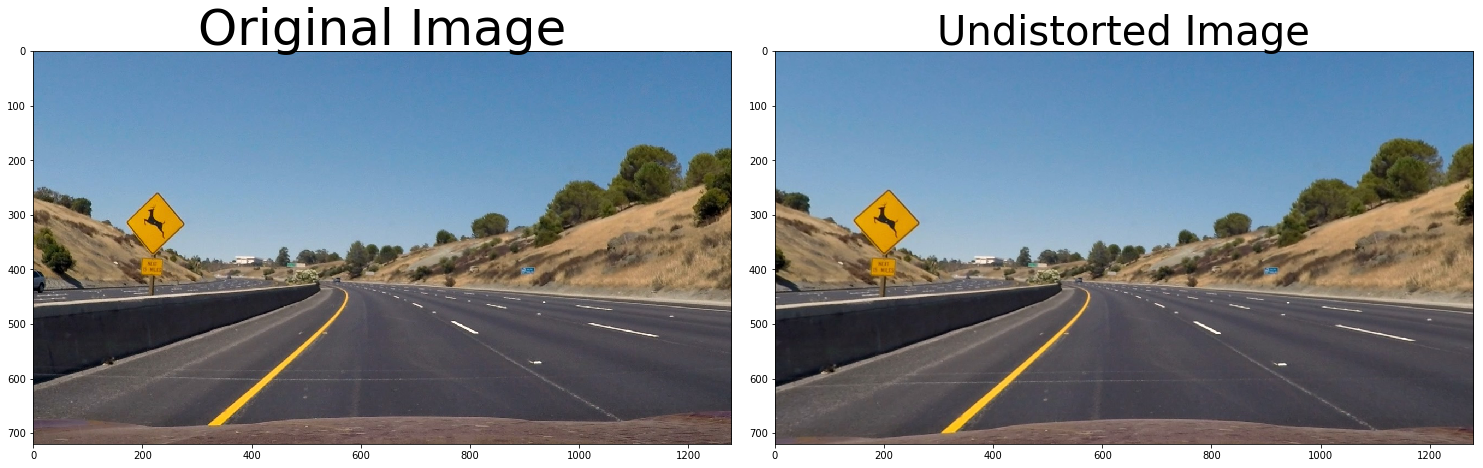

In [22]:
# Read a test image
img = mpimg.imread('test_images/test2.jpg')
undistort_image(img)

## Viewing Different Image Channels

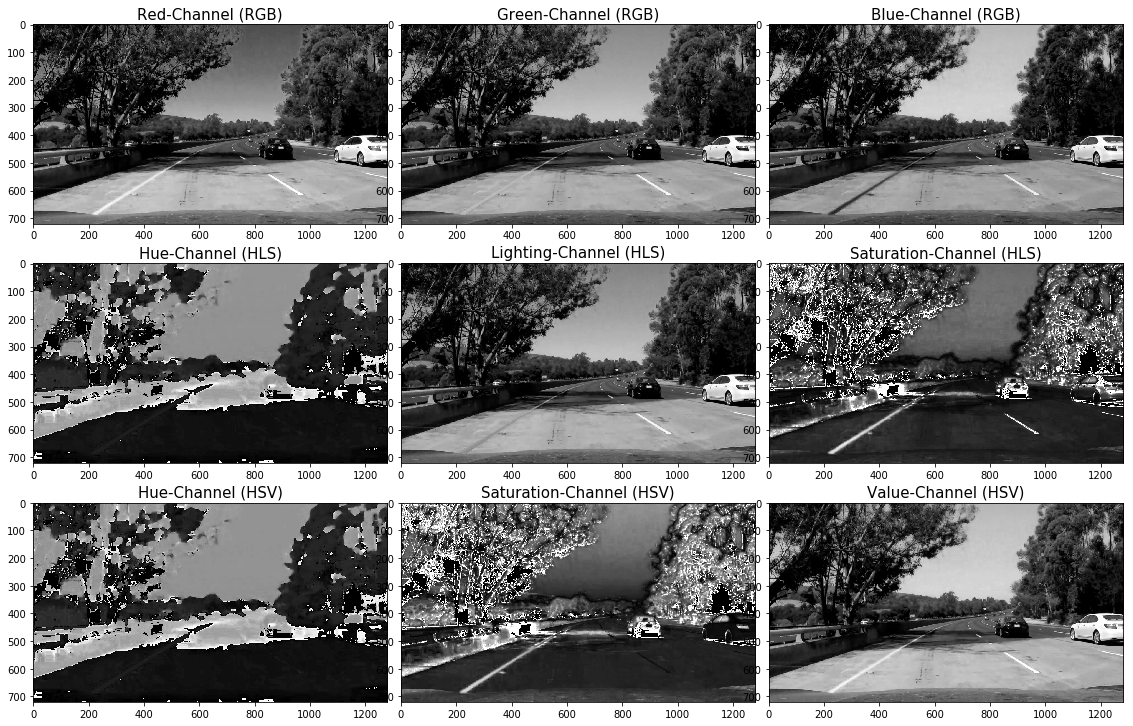

In [62]:
img = plt.imread('test_images/test5.jpg')

R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H1 = HLS[:,:,0]
L = HLS[:,:,1]
S1 = HLS[:,:,2]
HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
H2 = HSV[:,:,0]
S2 = HSV[:,:,1]
V = HSV[:,:,2]
fn, axes = plt.subplots(3, 3, figsize=(16, 10))
fn.tight_layout()
fn.subplots_adjust(hspace = .2, wspace=.01)

# Display R Channel
axes[0][0].imshow(R,cmap='gray')
axes[0][0].set_title('Red-Channel (RGB)', fontsize=15)
# Display G Channel
axes[0][1].imshow(G,cmap='gray')
axes[0][1].set_title('Green-Channel (RGB)', fontsize=15)
# Display B Channel
axes[0][2].imshow(B,cmap='gray')
axes[0][2].set_title('Blue-Channel (RGB)', fontsize=15)
# Display H Channel
axes[1][0].imshow(H1,cmap='gray')
axes[1][0].set_title('Hue-Channel (HLS)', fontsize=15)
# Display L Channel
axes[1][1].imshow(L,cmap='gray')
axes[1][1].set_title('Lighting-Channel (HLS)', fontsize=15)
# Display S Channel
axes[1][2].imshow(S1,cmap='gray')
axes[1][2].set_title('Saturation-Channel (HLS)', fontsize=15)
# Display H Channel
axes[2][0].imshow(H2,cmap='gray')
axes[2][0].set_title('Hue-Channel (HSV)', fontsize=15)
# Display S Channel
axes[2][1].imshow(S2,cmap='gray')
axes[2][1].set_title('Saturation-Channel (HSV)', fontsize=15)
# Display V Channel
axes[2][2].imshow(V,cmap='gray')
axes[2][2].set_title('Value-Channel (HSV)', fontsize=15)
plt.show()


## Gradient and Color Thresholds
* Experimenting different gradient and color threshlolds to detect different color lane lines

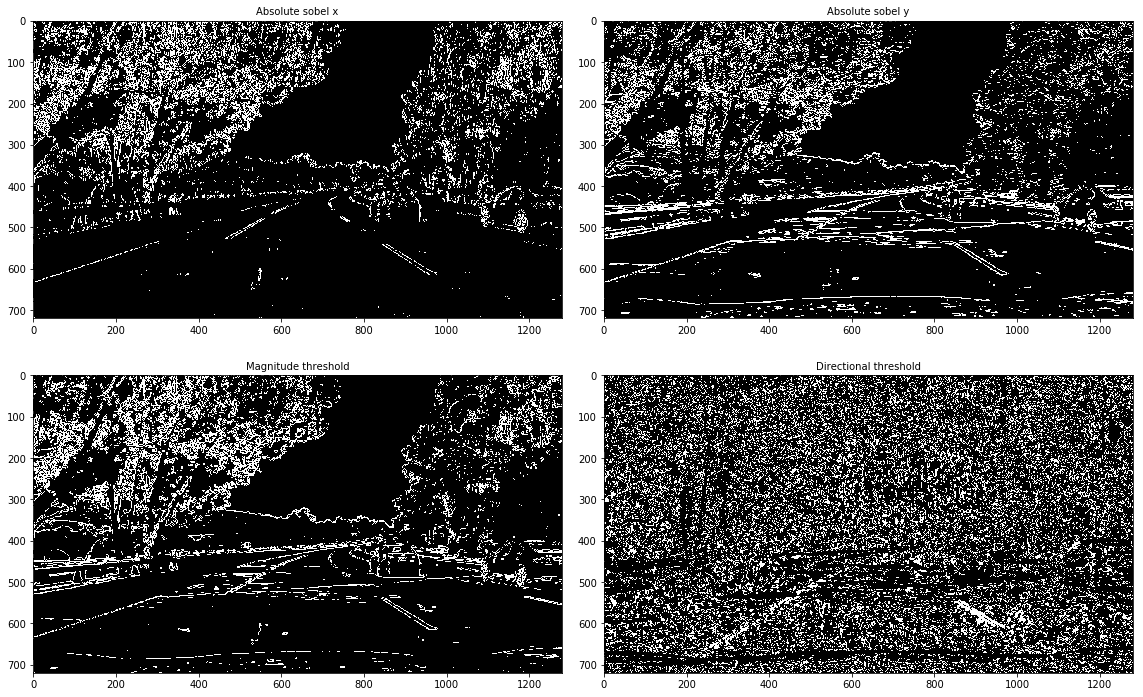

In [61]:
# Threshold - Computing magnitude of Gradient using Sobel x and y
# According to the lecture Sobel x which looks along the vertical axis performs a little better than sobel y
# Default sobel-kernel size=3 and threshold=<The entire range>
#reference - Udacity - Self Driving Car Nanodegree - Lesson 15, Topic 19

def magnitude_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Grayscaling
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # Sobel y gradient
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to unsigned 8 bit
    scale_factor = np.max(gradient_magnitude)/255 
    gradient_magnitude = (gradient_magnitude/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradient_magnitude)
    binary_output[(gradient_magnitude >= mag_thresh[0]) & (gradient_magnitude <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Apply threshold using absolute value of Sobel x or y
def absolute_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        sobel_absolute = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        sobel_absolute = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel_absolute/np.max(sobel_absolute))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Apply threshold for an image, given a range and Sobel kernel
def directional_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

kernelsize=3
fn, axes = plt.subplots(2, 2, figsize=(16, 10))
fn.subplots_adjust(hspace = .002, wspace=.001)
fn.tight_layout()

axes[0][0].set_title('Absolute sobel x', fontsize=10)
gradx = absolute_sobel_thresh(img, orient='x', sobel_kernel=kernelsize, thresh=(20, 100))
axes[0][0].imshow(gradx,cmap='gray')

axes[0][1].set_title('Absolute sobel y', fontsize=10)
grady = absolute_sobel_thresh(img, orient='y', sobel_kernel=kernelsize, thresh=(20, 100))
axes[0][1].imshow(grady,cmap='gray')

axes[1][0].set_title('Magnitude threshold', fontsize=10)
mag_binary = magnitude_thresh(img, sobel_kernel=kernelsize, mag_thresh=(30, 100))
axes[1][0].imshow(mag_binary,cmap='gray')

axes[1][1].set_title('Directional threshold', fontsize=10)
dir_binary = directional_threshold(img, sobel_kernel=15, thresh=(0.8, 1.2))
axes[1][1].imshow(dir_binary,cmap='gray')

## Combining Approaches to Undistort and Extract edges
We can see that the following approaches worked well.
* Sobel x operator.
* Saturation of HLS channel.
* Hue of HLS channel.

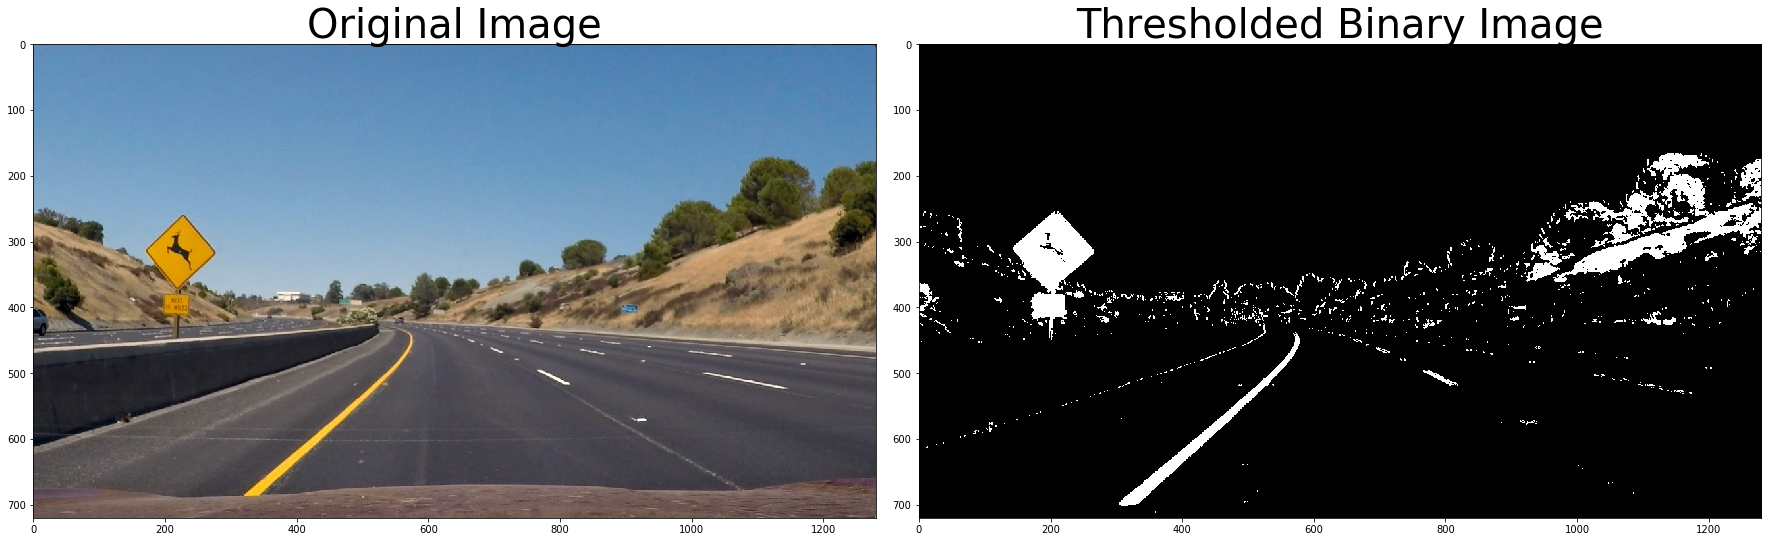

In [74]:
'''
Stack Sobel X, Hue and Saturation trhesholds of HLS channel together
'''
def pipeline_undistort_and_threshold(img, h_thresh=(15, 100), s_thresh=(100, 255), sx_thresh=(50, 150)):
    # Undistort the image
    img = np.copy(undistort(img))
    sx_binary = absolute_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=sx_thresh)
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]

    # Threshold saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Threshold hue
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    # Combining thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[((h_binary == 1) & (s_binary == 1)) | (sx_binary == 1)] = 1
    return combined_binary

img = mpimg.imread('test_images/test2.jpg')
result = pipeline_undistort_and_threshold(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)

## Perspective Transform
* Transforms the viewing angle
* The road lanes look to converge in the image but a perspective transform tells us if the road lanes actually curving.
* Methods used - getPerspectiveTransform and warpPerspective

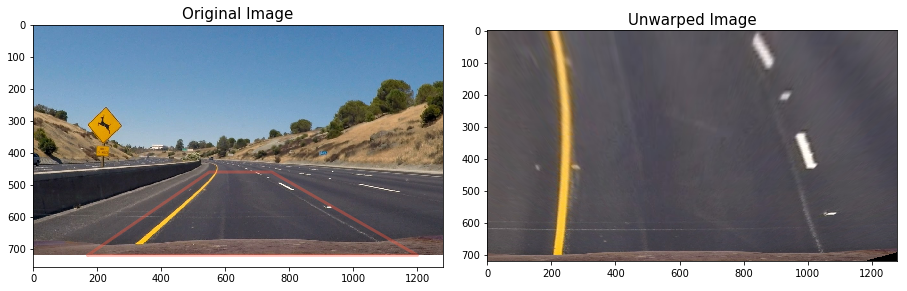

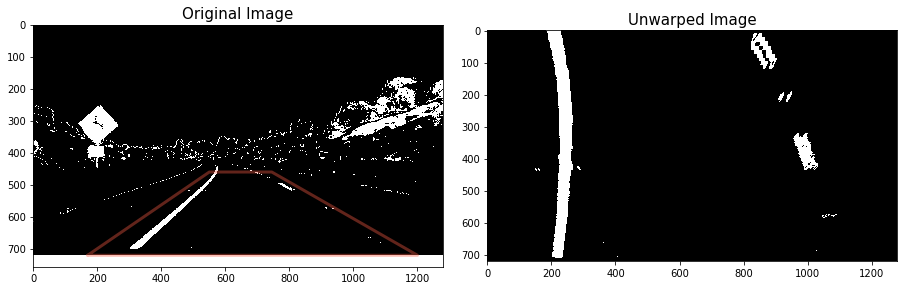

In [76]:
# Reference - Various QA from uUdacity forums.

def perspective_transform(img):
    h,w = img.shape[:2]
    # Define 4 source points (which takes shape of trapezoid)
    src = np.float32([[170, img.shape[0]], [550, 460], 
                      [745, 460], [1200, img.shape[0]]])
    # Define 4 destination points (which takes shape of rectangle)
    dst = np.float32([[100, img.shape[0]], [100, 0], 
                      [1100, 0], [1100, img.shape[0]]])
    # Compute the perspective transform, M, given source and destination points.
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped

def display_unwarped(img, cmap='hsv'):
    result,_,_,src = perspective_transform(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(img, cmap=cmap)
    ax1.set_title('Original Image', fontsize=15)
    x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
    ax1.plot(x, y, color='#f75b44', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

    ax2.imshow(result, cmap=cmap)
    ax2.set_title('Unwarped Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = mpimg.imread('test_images/test2.jpg')

#Image without perspective transform
display_unwarped(img)
#Image with perspective transform
display_unwarped(pipeline_undistort_and_threshold(img), cmap='gray')

## Finding the Lane lines in the warped image
* Use an image histogram to find the two peaks.
* Use those peaks as the starting point
* Use a sliding window approach to move vertically

### Reference - Udacity - Self Driving Car Nanodegree - Lesson 15, Topic 33(Finding Lines)


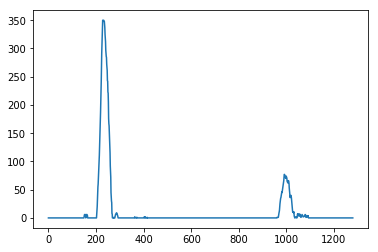

histogram shape (1280,)
leftx_base- 228
rightx_base- 991


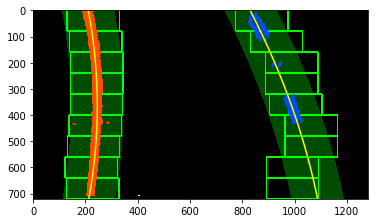

In [83]:
def sliding_window_poly_fit(binary_warped, show_image=True, nwindows = 9):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if show_image:
        # Print histogram from sliding window polyfit for example image
        plt.plot(histogram)
        plt.show()
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    print("histogram shape",histogram.shape)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    print("leftx_base-",leftx_base)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print("rightx_base-",rightx_base)
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if show_image:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonze`rox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    if left_fit is not None and right_fit is not None:
        # Generate x and y values for plotting
        ploty, left_fitx, right_fitx = generate_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)

        if show_image:
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)

    return left_fit, right_fit

def generate_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

img = mpimg.imread('test_images/test2.jpg')
binary_warped = perspective_transform_helper(undistort_and_threshold(img))
left_fit, right_fit = sliding_window_poly_fit(binary_warped)